# Manuscript Utils
This notebook contains useful functions for generating figures in the paper.

In [346]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from pylab import *
import os
from typing import Tuple, List

from dataclasses import dataclass

import sys
sys.path.append("../../python_src/")
from figures_utils import generate_experimental_df

# Global Variables and Replacement Dictionaries

In [347]:
name_replace_dict = {
    "biobakery3": "bioBakery3",
    "biobakery4": "bioBakery4",
    "bio4": "bioBakery4",
    "jams": "JAMS",
    "wgsa2": "WGSA2",
    "wgsa": "WGSA2",
    "woltka": "Woltka",
    "wol": "Woltka",
}

left_join_replace_dict = {"species_exp": "species", "genus_exp": "genus", "RA_obs": "RA"}

@dataclass
class LegendAddition:
    label: str
    color: str
    marker: str
    alpha: float

FP = LegendAddition("False Positive", "grey", "|", 0.5)
UNCLASS = LegendAddition("Unclassified", "#110a70", "x", 0.5)
ASSIGN_HIGHER = LegendAddition("Assigned Higher", "#f22e2e", "O", 0.5)

@dataclass
class Columns:
    false_positive: bool
    unclass: bool
    assigned_higher: bool

# If this taxonomy number comes into use, then it will be in the far, far future
ASSIGNED_HIGHER_ID = 999999999
UNCLASS_ID = 12908

## Expected Plotting
Stacked bar plots with tabulated relative abundances.

In [348]:
def get_all_expected(root_dir: str, rank="Genus") -> pd.DataFrame:
    combined_expected = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            # print("files: ", files)
            if f"expected_{rank.lower()}_annotated" in f and f.endswith(".csv"):
                # print(root, f)
                df = pd.read_csv(os.path.join(root, f), index_col=0, names=[rank, 'RA', "TAX_ID"], header=0)
                df["Source"] = root.split("/")[-1]

                # Files are of s#_expected.csv, so we can split on the underscore and take the first part.
                df["SampleID"] = f.split("_")[0]

                # Pipeline for easier grouping later.
                df['Pipeline'] = "Expected"

                combined_expected = pd.concat([combined_expected, df], axis=0)

    return combined_expected

def get_all_relabund_files(root_dir: str, rank="genus") -> pd.DataFrame:
    """
    Parameters:
        root_dir: str 
            The root directory to search for relabund files.
        rank: str
            The taxonomic rank to search for. Default is "genus".
    Returns:
        relabund_files: pd.DataFrame

    Traverses the BASE ROOT directory and searches for ALL {rank}_relabund_annotated files. These are concatenated. \\
    Then, it then returns a dataframe with the sample ID and the path to the relabund file.
    """
    combined_df = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if f"{rank.lower()}_relabund_annotated" in f and f.endswith(".csv"):
                # print(root, f)
                p = os.path.join(root, f)
                exp = generate_experimental_df(p, rank)
                exp["Pipeline"] = os.path.dirname(p).split('/')[-1]

                # Add a column to the experimental dataframe with the pipeline name.
                exp['Source'] = os.path.dirname(p).split('/')[-2]

                # Add sampleID to the experimental dataframe.
                exp['SampleID'] = os.path.basename(p).split('_')[0]
                # display(exp.head(10))

                # Add the experimental dataframe to the combined dataframe.
                combined_df = pd.concat([combined_df, exp], axis=0)

    # Ensure that the RA column is a float.
    combined_df['RA'] = combined_df['RA'].astype(float)

    return combined_df

# expected = get_all_expected("../../pipelines/", rank="Genus")
# display(expected.head(50))
# # Print the number of occurences in Source
# expected["Source"].value_counts()

In [349]:
def plot_pies(expected: pd.DataFrame):
    for source, source_df in expected.groupby("Source"):
        for sample, sample_df in source_df.groupby("SampleID"):
            plot_df = sample_df.loc[sample_df["RA"] > 0]

            plot_df[["RA"]].T.plot(kind="barh", stacked=True, figsize=(20, 10))
            plt.show()

            plt.pie(plot_df["RA"], labels=plot_df.index, autopct='%1.1f%%')
            plt.show()

            # sns.barplot(x='SampleID', y='RA', hue="Genus", data=plot_df)
            # plt.show()

## Creation of comparative stacked bar plots or heatmaps.

We want to create a figure that summarizes the relative abundances of the expected with comparison to each pipeline.

In [350]:
def get_legend_and_add_entry(ax: plt.Axes, c_objs: list[LegendAddition], contract: int = 15) -> Tuple[plt.Axes, str]:
    """
    Parameters:
        ax: plt.Axes
            The axes to add the legend entry to.
        c_objs: list
            A list of LegendAddition objects.
        contract: int
            The number of objects to contract the label to. Default is 15.
    Returns:
        ax: plt.Axes
            The axes with the legend entry added.
    Gets the legend from the axes and adds a new entry to it. \\
    """
    # Get the legend from the axes.
    handles, labels = ax.get_legend_handles_labels()

    if len (handles) >= contract:
        # We want only the top 15 entries.
        handles = handles[:contract]

    # Add the new legend entry.
    for obj in c_objs:
        handles.append(mpatches.Patch(color=obj.color, label=obj.label, hatch=obj.marker, alpha=obj.alpha))

    # Set the legend.
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)

    return ax

In [351]:
def add_row(df: pd.DataFrame, rank: str, name: str, value: any, taxid: float) -> pd.DataFrame:
    """
    Adds a row with the given value and name to the dataframe.
    """
    df.reset_index(inplace=True)
    df.index.names = [rank]

    new_row = pd.DataFrame({rank: name, "RA": value, "TAX_ID": taxid}, index=[0])
    df = pd.concat([df, new_row], axis=0)

    df = df.set_index(rank)

    return df

def fill_df(df: pd.DataFrame, src: str, rank: str, row_name: str = "Unclassified") -> Tuple[pd.DataFrame, bool]:
    """
    Parameters:
        df: pd.DataFrame
            The dataframe to fill.
        src: str
            The source of the dataframe.
        rank: str
            The taxonomic rank of the dataframe.
        row_name: str
            The name of the row which will fill. Default is "Unclassified".
    Returns:
        df: pd.DataFrame
            The dataframe with the row filled.
        filled: bool
            Whether or not the row was filled.
    
    Fills the input dataframe in the RA column up to 100% with a row of the input row_name. \\
    """
    # We need to get the sum of the RA column for the dataframe.
    # If it it less than 1, we need to fill the difference with a row called "Unclassified".
    df.reset_index(inplace=True)

    # Get the sum of the RA column.
    sum_ra = df["RA"].sum()
    diff = 1 - sum_ra
    # print(diff)

    # If the difference is less than zero, we do not need to add anything.
    if diff <= 0:
        df.set_index(rank, inplace=True)
        return df, False

    # Rename index to rank.
    df.index.names = [rank]

    # If the difference is greater than 0, we need to add a row.
    # new_row = pd.DataFrame({rank: "Unclassified", "RA": diff, "TAX_ID": "Unclassified", "Source": src, "SampleID": sampleID, "Pipeline": "wgsa2"}, index=[0])
    new_row = pd.DataFrame({rank: row_name, "RA": diff}, index=[0])
    df = pd.concat([df, new_row], axis=0)

    # print(df["RA"].sum())
    # display(df)

    df.set_index(rank, inplace=True)

    return df, True

In [352]:
def make_inverse_range(n: int) -> List[int]:
    # We want to take n (ex. 1) and make a range of [-2].
    # For n = 2, we want [-3, -2].
    # For n = 3, we want [-4, -3, -2].
    lst = []
    for i in range(n):
        lst.append(-i - 2)

    return reversed(lst)

def fix_bar_colors(ax: plt.Axes, labels_list: List[Tuple[str, str, str]]):
    """
    Changes the last bar in the ax to be black. We also need to change the second to last color to a hatched red? \\
    This is done because the legend entry "False Positive" is black and the last bar needs to match. Same for the "Unclassifed".

    Parameters:
        ax: plt.Axes
            The axes to change the color of.
        labels_list: List[Tuple[str, str, str]]
            A list of tuples containing the labels of the bars. The first index is the label name, the second is whether is it present or not, and the third is the color class.
            The order is 
    """
    children = ax.get_children()

    filtered = filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), children)
    filtered_list = list(filtered)

    def fix_color(rect, props: LegendAddition):
        rect.set_facecolor(props.color)
        rect.set_hatch(props.marker)
        rect.set_alpha(props.alpha)

    # false_p = filtered_list[-2]
    # unclass = filtered_list[-3]
    labels_list = [x for x in labels_list if x[1]]
    n = len(labels_list)

    idxs = make_inverse_range(n)

    for c, i in enumerate(make_inverse_range(n)):
        fix_color(filtered_list[i], labels_list[c][2])

    # filtered2 = filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), children)
    # list(filtered2)[-3].set_facecolor("#110a70").set_alpha(0.5)


In [353]:
def reorganize_columns(df: pd.DataFrame, cols_list: List[Tuple[str, bool]]):
    """
    Reorganizes the columns into the proper order so that colors may be assigned to the correct bars.
    Parameters:
        df: The dataframe to reorganize.
        cols_list: A list of tuples. The first element is the column name and the second is a boolean indicating if the column is present.
    """
    cols = list(df.columns.values)    

    reorg_list = [x[0] for x in cols_list if x[1]]

    for label in reorg_list:
        cols.pop(cols.index(label))
    
    return df[cols + reorg_list]

In [354]:
def add_plot_decorations(ax, n_rows):
    """
    This function adds a box around the pipelines and adds a textbox with the word "Observed" at 90 degrees.
    """
    # We now need to add an external rectangle to the first plot, the one enclosing the rest.
    autoAxis = ax[0].axis()
    rec = Rectangle((autoAxis[0]-0.15,autoAxis[2]),(autoAxis[1]-autoAxis[0]+0.151),(autoAxis[3]-autoAxis[2]),fill=False,lw=3)
    rec = ax[0].add_patch(rec)
    rec.set_clip_on(False)

    # Now, from the second axis down.
    autoAxis = ax[1].axis()
    box_height = autoAxis[3] - autoAxis[2] + 0.205
    height_mult = n_rows - 2
    # Distance between plots.
    rec = Rectangle((autoAxis[0]-0.15,autoAxis[2]-(box_height*height_mult)),(autoAxis[1]-autoAxis[0]+0.151),(autoAxis[3]-autoAxis[2]+(box_height*height_mult)),fill=False,lw=3)
    rec = ax[1].add_patch(rec)
    rec.set_clip_on(False)

    pts = rec.get_bbox()

    ax[1].text(pts.x0, pts.y0 / 2, "Observed", fontsize=24, ha="right", va="bottom", rotation=90)

    plt.show()

In [355]:
def plot_expected(ax: plt.Axes, df: pd.DataFrame, max_legend_entries: int = 15):
    """
    ## Parameters:
        ax: The axis to plot on.
        df: The dataframe to plot (should be the expected dataframe).
    
    Plots the expected values for the given ax.
    """
    group_T = df[["RA"]].T
    group_T.index = ["Expected"]
    group_T.plot.barh(stacked=True, ax=ax[0], alpha=0.5, legend=True, fontsize=20)

    ax[0].set_xlim(0, 1.01)

    ax[0] = get_legend_and_add_entry(ax[0], [UNCLASS, FP, ASSIGN_HIGHER], max_legend_entries)

In [356]:
def add_rows_to_expected(df: pd.DataFrame, rank: str) -> pd.DataFrame:
    df = add_row(df, rank, "Assigned Higher", 0.0, ASSIGNED_HIGHER_ID)
    df = add_row(df, rank, "Unclassified", 0.0, UNCLASS_ID)

    return df

In [357]:
def plot_one_to_one(smpl_df: pd.DataFrame, expected: pd.DataFrame, src: str, smpl: str, rank: str): 
    n_rows = len(smpl_df["Pipeline"].unique()) + 1

    fig, ax = plt.subplots(nrows=n_rows, ncols=1, figsize=(20, 10), sharex=True)
    fig.suptitle(f"Relative Abundances between Observed and Expected for {src} {smpl} at {rank.capitalize()} Level", fontsize=16, y=0.92)
    
    ax_c = 1

    grouped_expected = expected.loc[(expected["Source"] == src) & (expected["SampleID"] == smpl) & (expected["RA"] > 0)]
    sorted_expected = grouped_expected.copy().sort_index()
    # display(sorted_expected)
    plot_expected(ax, sorted_expected, 30)    

    # display(sorted_expected)
    sorted_expected = add_rows_to_expected(sorted_expected, rank)
    display(sorted_expected)

    # Get the TAX_ID values from the expected as a set.
    # We add 12908 becasue that is the TAX_ID for "Unclassified". We also add the assigned_higher ID (9 9s).
    # expected_tax_ids_set = set(sorted_expected["TAX_ID"].values)
    # expected_tax_ids_set.add(12908)
    # expected_tax_ids_set.add(ASSIGNED_HIGHER_ID)

    for pl, pl_df in smpl_df.groupby("Pipeline"):
        # Get observed total.
        observed_total = pl_df["RA"].sum()

        # The difference between 1 and the observed total is assigned higher.
        assigned_higher_ra = 0
        assigned_higher_bool = False

        if pl != "woltka":
            assigned_higher_ra = 1 - observed_total
            assigned_higher_bool = assigned_higher_ra > 1e-6

        # Add the assigned higher to the dataframe if it is greater than 1 ppm.
        if assigned_higher_bool:
            pl_df = add_row(pl_df, rank, "Assigned Higher", assigned_higher_ra, ASSIGNED_HIGHER_ID)

        # Select the rows from the observed that are in the expected set.
        # left_joined = pd.merge(grouped_expected, pl_df, how="left", on=["TAX_ID"], suffixes=("_obs", "_exp"))
        left_joined = sorted_expected.reset_index().merge(pl_df.reset_index(), how="left", on=["TAX_ID"], suffixes=("_exp", "_obs"))
        # pl_df = pl_df.loc[pl_df["TAX_ID"].isin(expected_tax_ids_set)]

        left_joined = left_joined.loc[(left_joined["RA_exp"].notna()) | (left_joined[f"{rank}_exp"] == "Unclassified") | (left_joined[f"{rank}_exp"] == "Assigned Higher")]
        left_joined = left_joined[[f"{rank}_exp", "RA_obs", "TAX_ID"]].fillna(0)
        left_joined.rename(left_join_replace_dict, axis=1, inplace=True)
        left_joined.set_index(rank, inplace=True)

        # display(pl_df)

        # Find the index value of the row with TAX_ID 12908.
        unclassified_present = 12908 in left_joined["TAX_ID"].values

        unclassified_label = None
        if unclassified_present:
            unclassified_label = left_joined.loc[left_joined["TAX_ID"] == 12908].index[0]

        left_joined, fp_filled = fill_df(left_joined, src, rank, "False Positive")
        # display(left_joined.head(10))
        T = left_joined[["RA"]].T

        # Sort the columns in alphabetical order.
        # T = T.reindex(sorted(T.columns), axis=1)

        # We need to remove the column "Unclassified" from the expected dataframe and remove the 'False Positive' column from the observed dataframe.
        # Then append these to the end of the df in the order "Unclass" then "False Positive", then Assign Higher.
        reorg_list = [(unclassified_label, unclassified_present, UNCLASS), ("False Positive", fp_filled, FP), ("Assigned Higher", assigned_higher_bool, ASSIGN_HIGHER)]

        T = reorganize_columns(T, reorg_list)
        
        # Change the index to the pipeline name.
        T.index = [name_replace_dict[pl]]

        display(T)

        ax[ax_c].set_xlim(0, 1.01)
        T.plot.barh(alpha=0.5, ax=ax[ax_c], legend=False, stacked=True, fontsize=20)
        # ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

        fix_bar_colors(ax[ax_c], reorg_list)

        ax[ax_c].set_xlabel("Relative Abundance", fontsize=24, labelpad=20)

        ax_c += 1

    add_plot_decorations(ax, n_rows) 

    pdf_output.savefig(fig, bbox_inches="tight", dpi=300)

bmock12
camisimGI
gut
hilo


,RA,TAX_ID,Source,SampleID,Pipeline
species,,,,,
AKKERMANSIA_MUCINIPHILA,0.0018,239935,hilo,expected,Expected
ALISTIPES_FINEGOLDII,0.0130,214856,hilo,expected,Expected
ANAEROSTIPES_HADRUS,0.0175,649756,hilo,expected,Expected
BACTEROIDES_THETAIOTAOMICRON,0.0772,818,hilo,expected,Expected
BACTEROIDES_UNIFORMIS,0.0105,820,hilo,expected,Expected
BIFIDOBACTERIUM_LONGUM,0.3702,216816,hilo,expected,Expected
BLAUTIA_WEXLERAE,0.0011,418240,hilo,expected,Expected
CLOSTRIDIUM_BUTYRICUM,0.1059,1492,hilo,expected,Expected
COLLINSELLA_AEROFACIENS,0.0199,74426,hilo,expected,Expected


bio4


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
AKKERMANSIA_MUCINIPHILA,0.001500,239935,bio4,hilo,SRR11487934
ALISTIPES_FINEGOLDII,0.000054,214856,bio4,hilo,SRR11487934
ANAEROSTIPES_HADRUS,0.012488,649756,bio4,hilo,SRR11487934
BACTEROIDES_THETAIOTAOMICRON,0.084528,818,bio4,hilo,SRR11487934
BACTEROIDES_UNIFORMIS,0.001863,820,bio4,hilo,SRR11487934
...,...,...,...,...,...
PARABACTEROIDES_DISTASONIS,0.131856,823,bio4,hilo,SRR11487931
PREVOTELLA_COPRI,0.127731,165179,bio4,hilo,SRR11487931
PREVOTELLA_MELANINOGENICA,0.027133,28132,bio4,hilo,SRR11487931


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.001500,239935
AKKERMANSIA_MUCINIPHILA,0.001057,239935
AKKERMANSIA_MUCINIPHILA,0.001553,239935
AKKERMANSIA_MUCINIPHILA,0.000937,239935
AKKERMANSIA_MUCINIPHILA,0.001403,239935
...,...,...
ROSEBURIA_INTESTINALIS,0.000558,166486
ROSEBURIA_INTESTINALIS,0.000638,166486
ROSEBURIA_INTESTINALIS,0.000755,166486


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.001290,239935.0
ALISTIPES_FINEGOLDII,0.000107,214856.0
ANAEROSTIPES_HADRUS,0.012992,649756.0
BACTEROIDES_THETAIOTAOMICRON,0.081847,818.0
BACTEROIDES_UNIFORMIS,0.002097,820.0
BIFIDOBACTERIUM_LONGUM,0.382897,216816.0
BLAUTIA_WEXLERAE,0.000185,418240.0
CLOSTRIDIUM_BUTYRICUM,0.015606,1492.0
COLLINSELLA_AEROFACIENS,0.017709,74426.0


species,AKKERMANSIA_MUCINIPHILA,ALISTIPES_FINEGOLDII,ANAEROSTIPES_HADRUS,BACTEROIDES_THETAIOTAOMICRON,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_WEXLERAE,CLOSTRIDIUM_BUTYRICUM,COLLINSELLA_AEROFACIENS,ESCHERICHIA_COLI,...,FAECALIBACTERIUM_PRAUSNITZII,LACTOBACILLUS_GASSERI,PARABACTEROIDES_DISTASONIS,PREVOTELLA_COPRI,PREVOTELLA_MELANINOGENICA,ROSEBURIA_HOMINIS,ROSEBURIA_INTESTINALIS,RUMINOCOCCUS_GAUVREAUII,Unclassified,Assigned Higher
RA,0.00129,0.000107,0.012992,0.081847,0.002097,0.382897,0.000185,0.015606,0.017709,0.163524,...,0.000524,0.0,0.134926,0.131903,0.028726,0.014748,0.000648,0.0,0.0,0.000111


jams


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
BIFIDOBACTERIUM_LONGUM,0.400586,216816,jams,hilo,SRR11487934
ESCHERICHIA_COLI,0.171014,562,jams,hilo,SRR11487934
PARABACTEROIDES_DISTASONIS,0.126842,823,jams,hilo,SRR11487934
BACTEROIDES_THETAIOTAOMICRON,0.103988,818,jams,hilo,SRR11487934
PREVOTELLA_COPRI,0.095757,165179,jams,hilo,SRR11487934
...,...,...,...,...,...
BACTEROIDES_BOUCHESDURHONENSIS,0.000000,1841855,jams,hilo,SRR11487931
BACTEROIDES_CACCAE,0.000000,47678,jams,hilo,SRR11487931
CLOSTRIDIUM_PERFRINGENS,0.000000,1502,jams,hilo,SRR11487931


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.000096,239935
AKKERMANSIA_MUCINIPHILA,0.000102,239935
AKKERMANSIA_MUCINIPHILA,0.000076,239935
AKKERMANSIA_MUCINIPHILA,0.000068,239935
AKKERMANSIA_MUCINIPHILA,0.000092,239935
...,...,...
Unclassified,0.001872,12908
Unclassified,0.002497,12908
Unclassified,0.000860,12908


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.000087,239935.0
ALISTIPES_FINEGOLDII,0.005687,214856.0
ANAEROSTIPES_HADRUS,0.005859,649756.0
BACTEROIDES_THETAIOTAOMICRON,0.102640,818.0
BACTEROIDES_UNIFORMIS,0.000036,820.0
BIFIDOBACTERIUM_LONGUM,0.404225,216816.0
BLAUTIA_WEXLERAE,0.000039,418240.0
CLOSTRIDIUM_BUTYRICUM,0.017651,1492.0
COLLINSELLA_AEROFACIENS,0.009512,74426.0


species,AKKERMANSIA_MUCINIPHILA,ALISTIPES_FINEGOLDII,ANAEROSTIPES_HADRUS,BACTEROIDES_THETAIOTAOMICRON,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_WEXLERAE,CLOSTRIDIUM_BUTYRICUM,COLLINSELLA_AEROFACIENS,ESCHERICHIA_COLI,...,FAECALIBACTERIUM_PRAUSNITZII,LACTOBACILLUS_GASSERI,PARABACTEROIDES_DISTASONIS,PREVOTELLA_COPRI,PREVOTELLA_MELANINOGENICA,ROSEBURIA_HOMINIS,ROSEBURIA_INTESTINALIS,RUMINOCOCCUS_GAUVREAUII,Unclassified,Assigned Higher
RA,0.000087,0.005687,0.005859,0.10264,0.000036,0.404225,0.000039,0.017651,0.009512,0.16803,...,0.000022,0.000005,0.126293,0.098024,0.017287,0.006896,0.000046,0.000046,0.001478,0.031968


wgsa


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
Bifidobacterium longum,3.859819e-01,216816,wgsa,hilo,SRR11487934
Bacteroides thetaiotaomicron,9.822610e-02,818,wgsa,hilo,SRR11487934
Parabacteroides distasonis,8.122702e-02,823,wgsa,hilo,SRR11487934
Prevotella copri,6.563605e-02,165179,wgsa,hilo,SRR11487934
Escherichia coli,5.645775e-02,562,wgsa,hilo,SRR11487934
...,...,...,...,...,...
Enterobacter sp. E20,5.109596e-07,1560339,wgsa,hilo,SRR11487931
Enterobacter sp. ODB01,5.109596e-07,1827481,wgsa,hilo,SRR11487931
Enterobacter sp. RHBSTW-00593,5.109596e-07,2742656,wgsa,hilo,SRR11487931


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.001464,239935
AKKERMANSIA_MUCINIPHILA,0.001417,239935
AKKERMANSIA_MUCINIPHILA,0.001409,239935
AKKERMANSIA_MUCINIPHILA,0.001306,239935
AKKERMANSIA_MUCINIPHILA,0.001431,239935
...,...,...
Unclassified,0.026639,12908
Unclassified,0.026306,12908
Unclassified,0.027902,12908


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.001405,239935.0
ALISTIPES_FINEGOLDII,0.010668,214856.0
ANAEROSTIPES_HADRUS,0.007600,649756.0
BACTEROIDES_THETAIOTAOMICRON,0.097250,818.0
BACTEROIDES_UNIFORMIS,0.001961,820.0
BIFIDOBACTERIUM_LONGUM,0.387967,216816.0
BLAUTIA_WEXLERAE,0.000000,418240.0
CLOSTRIDIUM_BUTYRICUM,0.025205,1492.0
COLLINSELLA_AEROFACIENS,0.009425,74426.0


species,AKKERMANSIA_MUCINIPHILA,ALISTIPES_FINEGOLDII,ANAEROSTIPES_HADRUS,BACTEROIDES_THETAIOTAOMICRON,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_WEXLERAE,CLOSTRIDIUM_BUTYRICUM,COLLINSELLA_AEROFACIENS,ESCHERICHIA_COLI,...,FAECALIBACTERIUM_PRAUSNITZII,LACTOBACILLUS_GASSERI,PARABACTEROIDES_DISTASONIS,PREVOTELLA_COPRI,PREVOTELLA_MELANINOGENICA,ROSEBURIA_HOMINIS,ROSEBURIA_INTESTINALIS,RUMINOCOCCUS_GAUVREAUII,Unclassified,Assigned Higher
RA,0.001405,0.010668,0.0076,0.09725,0.001961,0.387967,0.0,0.025205,0.009425,0.054887,...,0.001001,0.000024,0.080181,0.067042,0.017132,0.010263,0.001011,0.0,0.027169,0.192619


wol


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
Escherichia coli,2.933151e-01,562,wol,hilo,SRR11487934
Bifidobacterium longum,1.277085e-01,216816,wol,hilo,SRR11487934
Bacteroides thetaiotaomicron,1.111787e-01,818,wol,hilo,SRR11487934
Parabacteroides distasonis,9.331321e-02,823,wol,hilo,SRR11487934
Prevotella copri,7.137284e-02,165179,wol,hilo,SRR11487934
...,...,...,...,...,...
Zhongshania aliphaticivorans,1.847297e-07,1470434,wol,hilo,SRR11487931
Francisella tularensis,1.847297e-07,263,wol,hilo,SRR11487931
Eisenbergiella tayi,1.847297e-07,1432052,wol,hilo,SRR11487931


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.001408,239935
AKKERMANSIA_MUCINIPHILA,0.001329,239935
AKKERMANSIA_MUCINIPHILA,0.001406,239935
AKKERMANSIA_MUCINIPHILA,0.001277,239935
AKKERMANSIA_MUCINIPHILA,0.001383,239935
...,...,...
RUMINOCOCCUS_GAUVREAUII,0.000929,438033
RUMINOCOCCUS_GAUVREAUII,0.000896,438033
RUMINOCOCCUS_GAUVREAUII,0.000936,438033


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.001361,239935.0
ALISTIPES_FINEGOLDII,0.008827,214856.0
ANAEROSTIPES_HADRUS,0.005768,649756.0
BACTEROIDES_THETAIOTAOMICRON,0.110941,818.0
BACTEROIDES_UNIFORMIS,0.002348,820.0
BIFIDOBACTERIUM_LONGUM,0.125593,216816.0
BLAUTIA_WEXLERAE,0.000000,418240.0
CLOSTRIDIUM_BUTYRICUM,0.023141,1492.0
COLLINSELLA_AEROFACIENS,0.005384,74426.0


species,AKKERMANSIA_MUCINIPHILA,ALISTIPES_FINEGOLDII,ANAEROSTIPES_HADRUS,BACTEROIDES_THETAIOTAOMICRON,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_WEXLERAE,CLOSTRIDIUM_BUTYRICUM,COLLINSELLA_AEROFACIENS,ESCHERICHIA_COLI,...,FAECALIBACTERIUM_PRAUSNITZII,LACTOBACILLUS_GASSERI,PARABACTEROIDES_DISTASONIS,PREVOTELLA_COPRI,PREVOTELLA_MELANINOGENICA,ROSEBURIA_HOMINIS,ROSEBURIA_INTESTINALIS,RUMINOCOCCUS_GAUVREAUII,Unclassified,Assigned Higher
RA,0.001361,0.008827,0.005768,0.110941,0.002348,0.125593,0.0,0.023141,0.005384,0.296908,...,0.000845,0.000228,0.090803,0.071232,0.012465,0.007726,0.000923,0.00092,0.0,0.229595


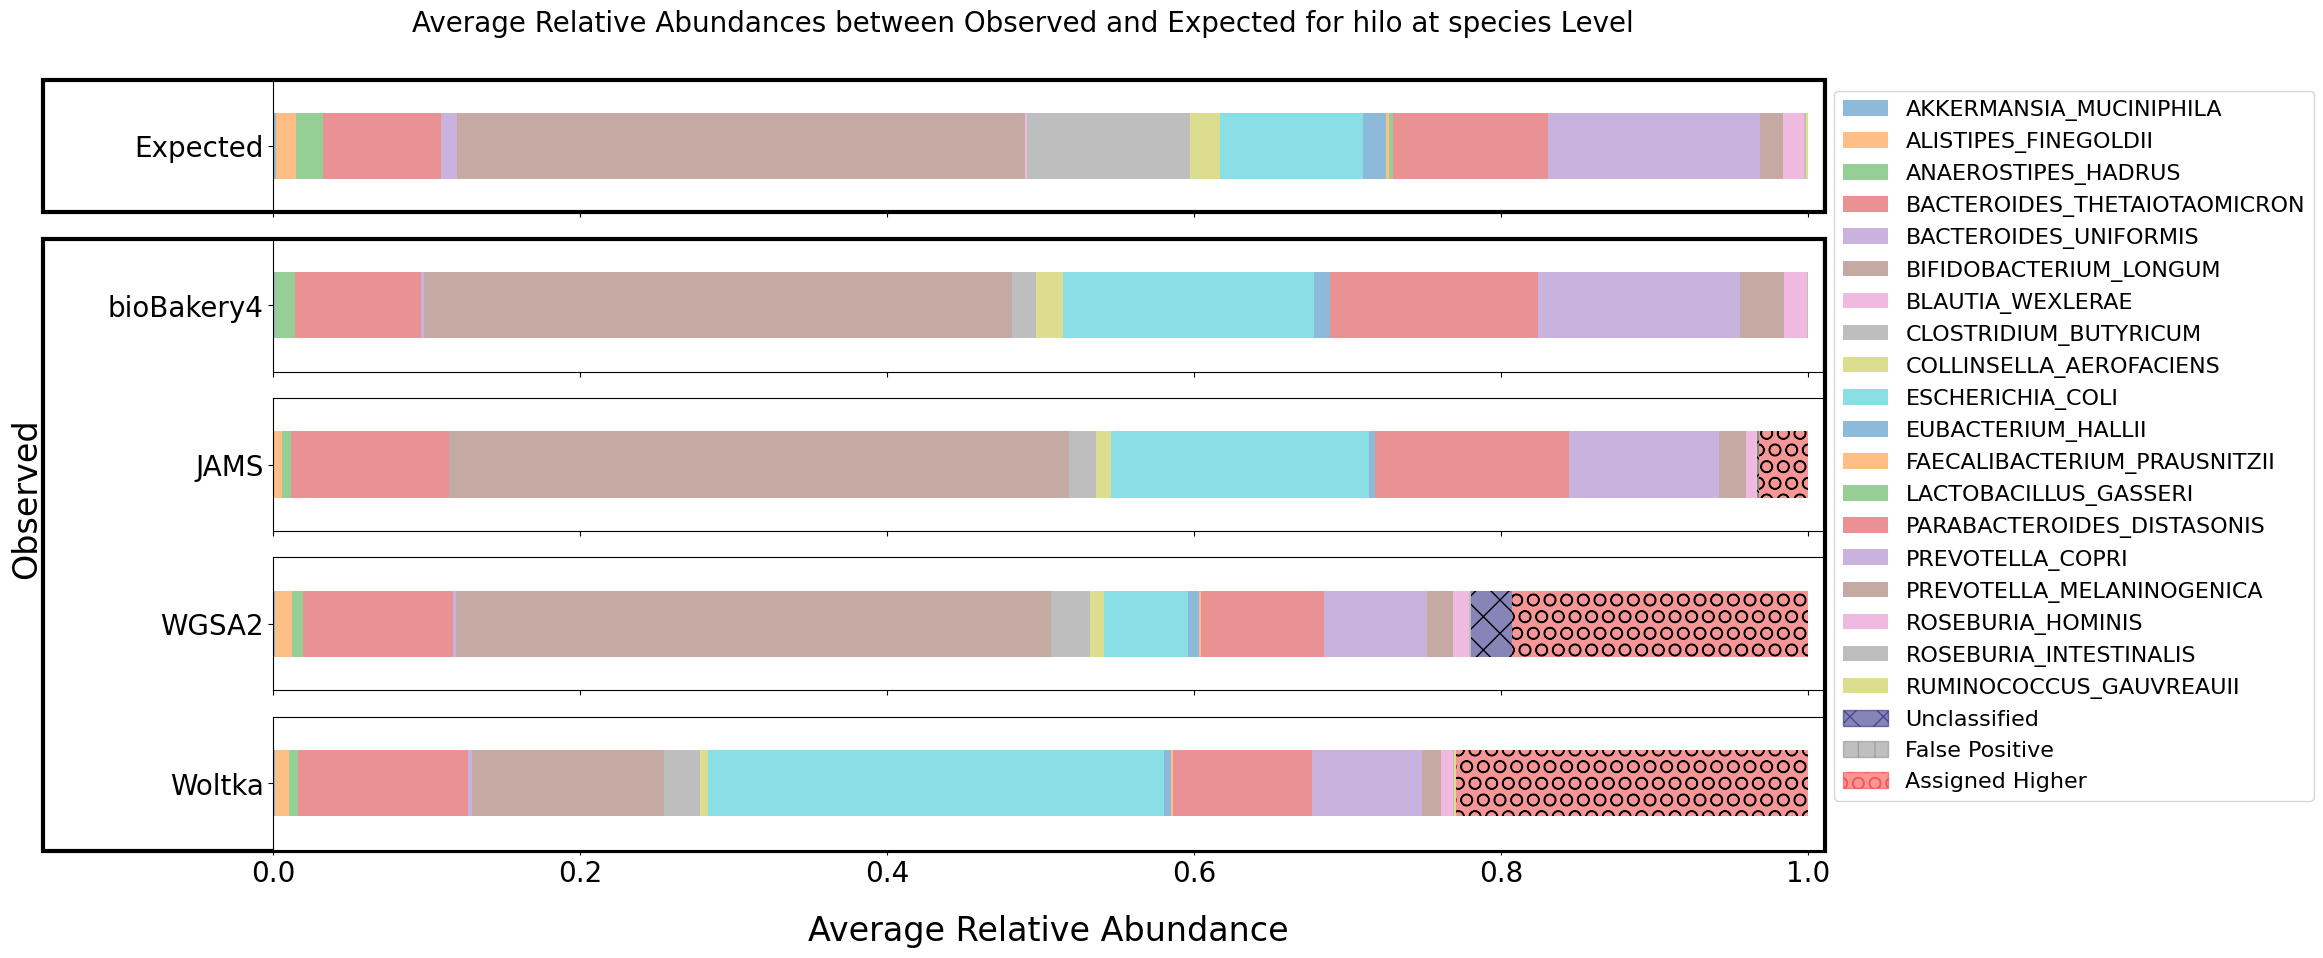

mixed


,RA,TAX_ID,Source,SampleID,Pipeline
species,,,,,
AKKERMANSIA_MUCINIPHILA,0.0637,239935,mixed,expected,Expected
ALISTIPES_FINEGOLDII,0.0454,214856,mixed,expected,Expected
ANAEROSTIPES_HADRUS,0.0611,649756,mixed,expected,Expected
BACTEROIDES_THETAIOTAOMICRON,0.0269,818,mixed,expected,Expected
BACTEROIDES_UNIFORMIS,0.0366,820,mixed,expected,Expected
BIFIDOBACTERIUM_LONGUM,0.1292,216816,mixed,expected,Expected
BLAUTIA_WEXLERAE,0.0377,418240,mixed,expected,Expected
CLOSTRIDIUM_BUTYRICUM,0.0370,1492,mixed,expected,Expected
COLLINSELLA_AEROFACIENS,0.0695,74426,mixed,expected,Expected


bio4


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
AKKERMANSIA_MUCINIPHILA,0.072827,239935,bio4,mixed,SRR11487938
ALISTIPES_FINEGOLDII,0.001110,214856,bio4,mixed,SRR11487938
ANAEROSTIPES_HADRUS,0.049479,649756,bio4,mixed,SRR11487938
BACTEROIDES_THETAIOTAOMICRON,0.048322,818,bio4,mixed,SRR11487938
BACTEROIDES_UNIFORMIS,0.045981,820,bio4,mixed,SRR11487938
...,...,...,...,...,...
PARABACTEROIDES_DISTASONIS,0.052844,823,bio4,mixed,SRR11487937
PREVOTELLA_COPRI,0.056616,165179,bio4,mixed,SRR11487937
PREVOTELLA_MELANINOGENICA,0.114070,28132,bio4,mixed,SRR11487937


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.072827,239935
AKKERMANSIA_MUCINIPHILA,0.070572,239935
AKKERMANSIA_MUCINIPHILA,0.069618,239935
AKKERMANSIA_MUCINIPHILA,0.072491,239935
AKKERMANSIA_MUCINIPHILA,0.074257,239935
...,...,...
ROSEBURIA_INTESTINALIS,0.041684,166486
ROSEBURIA_INTESTINALIS,0.040173,166486
ROSEBURIA_INTESTINALIS,0.043730,166486


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.071953,239935.0
ALISTIPES_FINEGOLDII,0.000626,214856.0
ANAEROSTIPES_HADRUS,0.050266,649756.0
BACTEROIDES_THETAIOTAOMICRON,0.048550,818.0
BACTEROIDES_UNIFORMIS,0.046067,820.0
BIFIDOBACTERIUM_LONGUM,0.157077,216816.0
BLAUTIA_WEXLERAE,0.034079,418240.0
CLOSTRIDIUM_BUTYRICUM,0.005984,1492.0
COLLINSELLA_AEROFACIENS,0.080211,74426.0


species,AKKERMANSIA_MUCINIPHILA,ALISTIPES_FINEGOLDII,ANAEROSTIPES_HADRUS,BACTEROIDES_THETAIOTAOMICRON,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_WEXLERAE,CLOSTRIDIUM_BUTYRICUM,COLLINSELLA_AEROFACIENS,ESCHERICHIA_COLI,...,FAECALIBACTERIUM_PRAUSNITZII,LACTOBACILLUS_GASSERI,PARABACTEROIDES_DISTASONIS,PREVOTELLA_COPRI,PREVOTELLA_MELANINOGENICA,ROSEBURIA_HOMINIS,ROSEBURIA_INTESTINALIS,RUMINOCOCCUS_GAUVREAUII,Unclassified,Assigned Higher
RA,0.071953,0.000626,0.050266,0.04855,0.046067,0.157077,0.034079,0.005984,0.080211,0.050903,...,0.036795,0.007935,0.051557,0.05545,0.113127,0.061669,0.041804,0.0,0.0,0.038641


jams


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
BIFIDOBACTERIUM_LONGUM,0.177041,216816,jams,mixed,SRR11487938
PREVOTELLA_MELANINOGENICA,0.074157,28132,jams,mixed,SRR11487938
BACTEROIDES_THETAIOTAOMICRON,0.060288,818,jams,mixed,SRR11487938
COLLINSELLA_AEROFACIENS,0.052558,74426,jams,mixed,SRR11487938
ALISTIPES_FINEGOLDII,0.052373,214856,jams,mixed,SRR11487938
...,...,...,...,...,...
CLOSTRIDIUM_SPOROGENES,0.000000,1509,jams,mixed,SRR11487937
CLOSTRIDIUM_SACCHAROPERBUTYLACETONICUM,0.000000,36745,jams,mixed,SRR11487937
CLOSTRIDIUM_POLYENDOSPORUM,0.000000,69208,jams,mixed,SRR11487937


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.050590,239935
AKKERMANSIA_MUCINIPHILA,0.050177,239935
AKKERMANSIA_MUCINIPHILA,0.048901,239935
AKKERMANSIA_MUCINIPHILA,0.049469,239935
AKKERMANSIA_MUCINIPHILA,0.049211,239935
...,...,...
Unclassified,0.000726,12908
Unclassified,0.001131,12908
Unclassified,0.002344,12908


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.049669,239935.0
ALISTIPES_FINEGOLDII,0.051751,214856.0
ANAEROSTIPES_HADRUS,0.031637,649756.0
BACTEROIDES_THETAIOTAOMICRON,0.057585,818.0
BACTEROIDES_UNIFORMIS,0.021514,820.0
BIFIDOBACTERIUM_LONGUM,0.177387,216816.0
BLAUTIA_WEXLERAE,0.042371,418240.0
CLOSTRIDIUM_BUTYRICUM,0.004779,1492.0
COLLINSELLA_AEROFACIENS,0.052334,74426.0


species,AKKERMANSIA_MUCINIPHILA,ALISTIPES_FINEGOLDII,ANAEROSTIPES_HADRUS,BACTEROIDES_THETAIOTAOMICRON,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_WEXLERAE,CLOSTRIDIUM_BUTYRICUM,COLLINSELLA_AEROFACIENS,ESCHERICHIA_COLI,...,FAECALIBACTERIUM_PRAUSNITZII,LACTOBACILLUS_GASSERI,PARABACTEROIDES_DISTASONIS,PREVOTELLA_COPRI,PREVOTELLA_MELANINOGENICA,ROSEBURIA_HOMINIS,ROSEBURIA_INTESTINALIS,RUMINOCOCCUS_GAUVREAUII,Unclassified,Assigned Higher
RA,0.049669,0.051751,0.031637,0.057585,0.021514,0.177387,0.042371,0.004779,0.052334,0.044921,...,0.035353,0.004812,0.044672,0.043616,0.07402,0.045537,0.038292,0.046021,0.001447,0.098204


wgsa


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
Bifidobacterium longum,1.739465e-01,216816,wgsa,mixed,SRR11487938
unclassified,8.454132e-02,12908,wgsa,mixed,SRR11487938
Prevotella melaninogenica,7.001220e-02,28132,wgsa,mixed,SRR11487938
Bacteroides thetaiotaomicron,6.144117e-02,818,wgsa,mixed,SRR11487938
Alistipes finegoldii,5.170621e-02,214856,wgsa,mixed,SRR11487938
...,...,...,...,...,...
Synechocystis sp. PCC 7338,5.087691e-07,2732530,wgsa,mixed,SRR11487937
Neorhizobium sp. SOG26,5.087691e-07,2060726,wgsa,mixed,SRR11487937
Conexibacter woesei,5.087691e-07,191495,wgsa,mixed,SRR11487937


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.050806,239935
AKKERMANSIA_MUCINIPHILA,0.050349,239935
AKKERMANSIA_MUCINIPHILA,0.049254,239935
AKKERMANSIA_MUCINIPHILA,0.049798,239935
AKKERMANSIA_MUCINIPHILA,0.049532,239935
...,...,...
Unclassified,0.084541,12908
Unclassified,0.084535,12908
Unclassified,0.085719,12908


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.049948,239935.0
ALISTIPES_FINEGOLDII,0.051235,214856.0
ANAEROSTIPES_HADRUS,0.029031,649756.0
BACTEROIDES_THETAIOTAOMICRON,0.060930,818.0
BACTEROIDES_UNIFORMIS,0.033980,820.0
BIFIDOBACTERIUM_LONGUM,0.173755,216816.0
BLAUTIA_WEXLERAE,0.000000,418240.0
CLOSTRIDIUM_BUTYRICUM,0.010478,1492.0
COLLINSELLA_AEROFACIENS,0.044414,74426.0


species,AKKERMANSIA_MUCINIPHILA,ALISTIPES_FINEGOLDII,ANAEROSTIPES_HADRUS,BACTEROIDES_THETAIOTAOMICRON,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_WEXLERAE,CLOSTRIDIUM_BUTYRICUM,COLLINSELLA_AEROFACIENS,ESCHERICHIA_COLI,...,FAECALIBACTERIUM_PRAUSNITZII,LACTOBACILLUS_GASSERI,PARABACTEROIDES_DISTASONIS,PREVOTELLA_COPRI,PREVOTELLA_MELANINOGENICA,ROSEBURIA_HOMINIS,ROSEBURIA_INTESTINALIS,RUMINOCOCCUS_GAUVREAUII,Unclassified,Assigned Higher
RA,0.049948,0.051235,0.029031,0.06093,0.03398,0.173755,0.0,0.010478,0.044414,0.018656,...,0.037189,0.000886,0.033225,0.030963,0.069855,0.045069,0.039288,0.0,0.08518,0.151484


wol


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
Escherichia coli,1.059841e-01,562,wol,mixed,SRR11487938
Bacteroides thetaiotaomicron,7.425005e-02,818,wol,mixed,SRR11487938
Bifidobacterium longum,5.844414e-02,216816,wol,mixed,SRR11487938
Prevotella melaninogenica,5.284298e-02,28132,wol,mixed,SRR11487938
Akkermansia muciniphila,5.166434e-02,239935,wol,mixed,SRR11487938
...,...,...,...,...,...
Firmicutes bacterium CAG:176_59_8,1.980421e-07,1897030,wol,mixed,SRR11487937
Anaerophaga thermohalophila,1.980421e-07,177400,wol,mixed,SRR11487937
bacterium F082,1.980421e-07,1768115,wol,mixed,SRR11487937


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.051664,239935
AKKERMANSIA_MUCINIPHILA,0.052121,239935
AKKERMANSIA_MUCINIPHILA,0.051037,239935
AKKERMANSIA_MUCINIPHILA,0.051343,239935
AKKERMANSIA_MUCINIPHILA,0.049779,239935
...,...,...
RUMINOCOCCUS_GAUVREAUII,0.033337,438033
RUMINOCOCCUS_GAUVREAUII,0.035037,438033
RUMINOCOCCUS_GAUVREAUII,0.033537,438033


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.051189,239935.0
ALISTIPES_FINEGOLDII,0.043529,214856.0
ANAEROSTIPES_HADRUS,0.023372,649756.0
BACTEROIDES_THETAIOTAOMICRON,0.074048,818.0
BACTEROIDES_UNIFORMIS,0.033042,820.0
BIFIDOBACTERIUM_LONGUM,0.058549,216816.0
BLAUTIA_WEXLERAE,0.000000,418240.0
CLOSTRIDIUM_BUTYRICUM,0.009697,1492.0
COLLINSELLA_AEROFACIENS,0.026790,74426.0


species,AKKERMANSIA_MUCINIPHILA,ALISTIPES_FINEGOLDII,ANAEROSTIPES_HADRUS,BACTEROIDES_THETAIOTAOMICRON,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_WEXLERAE,CLOSTRIDIUM_BUTYRICUM,COLLINSELLA_AEROFACIENS,ESCHERICHIA_COLI,...,FAECALIBACTERIUM_PRAUSNITZII,LACTOBACILLUS_GASSERI,PARABACTEROIDES_DISTASONIS,PREVOTELLA_COPRI,PREVOTELLA_MELANINOGENICA,ROSEBURIA_HOMINIS,ROSEBURIA_INTESTINALIS,RUMINOCOCCUS_GAUVREAUII,Unclassified,Assigned Higher
RA,0.051189,0.043529,0.023372,0.074048,0.033042,0.058549,0.0,0.009697,0.02679,0.104924,...,0.029189,0.008371,0.039919,0.034995,0.053094,0.03743,0.03024,0.03425,0.0,0.282283


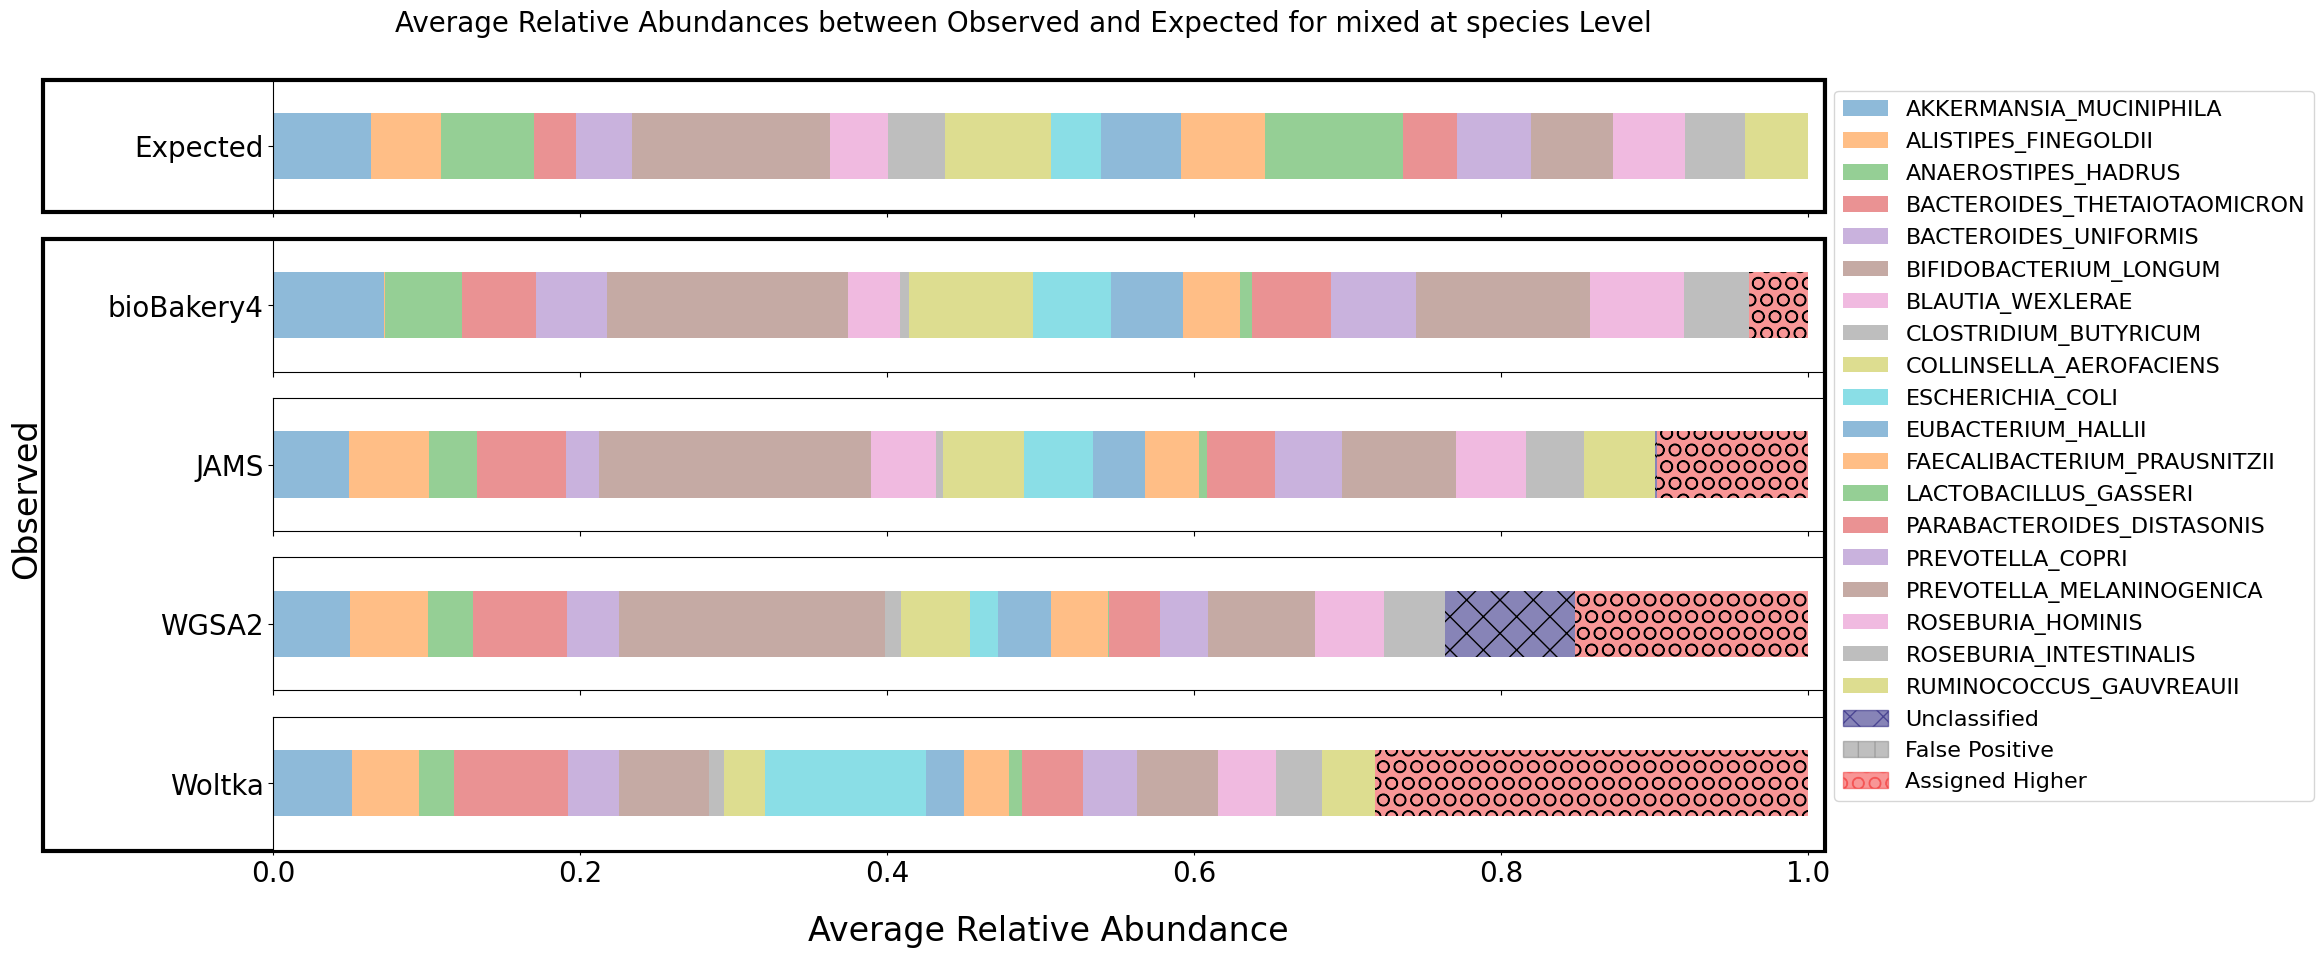

nist
tongue
tourlousse


,RA,TAX_ID,Source,SampleID,Pipeline
species,,,,,
AKKERMANSIA_MUCINIPHILA,0.060,239935,tourlousse,expected,Expected
ANAEROSTIPES_CACCAE,0.053,105841,tourlousse,expected,Expected
BACILLUS_SUBTILIS,0.052,1423,tourlousse,expected,Expected
BACTEROIDES_UNIFORMIS,0.047,820,tourlousse,expected,Expected
BIFIDOBACTERIUM_LONGUM,0.100,216816,tourlousse,expected,Expected
BLAUTIA_SP._NBRC-113351,0.045,2877527,tourlousse,expected,Expected
COLLINSELLA_AEROFACIENS,0.062,74426,tourlousse,expected,Expected
CUTIBACTERIUM_ACNES,0.050,1747,tourlousse,expected,Expected
ENTEROCLOSTER_CLOSTRIDIOFORMIS,0.053,1531,tourlousse,expected,Expected


bio4


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
AKKERMANSIA_MUCINIPHILA,0.048716,239935,bio4,tourlousse,SRR17380246
ANAEROSTIPES_CACCAE,0.066472,105841,bio4,tourlousse,SRR17380246
BACILLUS_INTESTINALIS,0.005337,1963032,bio4,tourlousse,SRR17380246
BACILLUS_MURIMARTINI,0.036839,171685,bio4,tourlousse,SRR17380246
BACTEROIDES_UNIFORMIS,0.060071,820,bio4,tourlousse,SRR17380246
...,...,...,...,...,...
PARABACTEROIDES_DISTASONIS,0.062993,823,bio4,tourlousse,SRR17380245
PSEUDOMONAS_PUTIDA_GROUP,0.007707,136845,bio4,tourlousse,SRR17380245
RUMINOCOCCUS_GNAVUS,0.073125,33038,bio4,tourlousse,SRR17380245


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.048716,239935
AKKERMANSIA_MUCINIPHILA,0.047959,239935
AKKERMANSIA_MUCINIPHILA,0.048368,239935
AKKERMANSIA_MUCINIPHILA,0.049999,239935
AKKERMANSIA_MUCINIPHILA,0.048618,239935
...,...,...
STREPTOCOCCUS_MUTANS,0.079539,1309
STREPTOCOCCUS_MUTANS,0.074096,1309
STREPTOCOCCUS_MUTANS,0.076107,1309


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.048728,239935.0
ANAEROSTIPES_CACCAE,0.065519,105841.0
BACILLUS_SUBTILIS,0.000000,1423.0
BACTEROIDES_UNIFORMIS,0.059636,820.0
BIFIDOBACTERIUM_LONGUM,0.105177,216816.0
BLAUTIA_SP._NBRC-113351,0.000000,2877527.0
COLLINSELLA_AEROFACIENS,0.049738,74426.0
CUTIBACTERIUM_ACNES,0.058274,1747.0
ENTEROCLOSTER_CLOSTRIDIOFORMIS,0.064817,1531.0


species,AKKERMANSIA_MUCINIPHILA,ANAEROSTIPES_CACCAE,BACILLUS_SUBTILIS,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_SP._NBRC-113351,COLLINSELLA_AEROFACIENS,CUTIBACTERIUM_ACNES,ENTEROCLOSTER_CLOSTRIDIOFORMIS,ESCHERICHIA_COLI,...,LACTOBACILLUS_DELBRUECKII,MEGAMONAS_FUNIFORMIS,MEGASPHAERA_MASSILIENSIS,PARABACTEROIDES_DISTASONIS,PSEUDOMONAS_PUTIDA,RUMINOCOCCUS_GNAVUS,STAPHYLOCOCCUS_EPIDERMIDIS,STREPTOCOCCUS_MUTANS,Unclassified,Assigned Higher
RA,0.048728,0.065519,0.0,0.059636,0.105177,0.0,0.049738,0.058274,0.064817,0.071108,...,0.042601,0.007025,0.0,0.063213,0.0,0.073032,0.051924,0.07768,0.0,0.122308


jams


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
ENTEROCLOSTER_CLOSTRIDIOFORMIS,0.081019,1531,jams,tourlousse,SRR17380246
ESCHERICHIA_COLI,0.073891,562,jams,tourlousse,SRR17380246
PARABACTEROIDES_DISTASONIS,0.072905,823,jams,tourlousse,SRR17380246
PSEUDOMONAS_PUTIDA,0.072586,303,jams,tourlousse,SRR17380246
BACTEROIDES_UNIFORMIS,0.068413,820,jams,tourlousse,SRR17380246
...,...,...,...,...,...
BACTEROIDES_XYLANISOLVENS,0.000000,371601,jams,tourlousse,SRR17380245
BLAUTIA_SP._AM47-4,0.000000,2292979,jams,tourlousse,SRR17380245
CITROBACTER_SP._RHBSTW-00053,0.000000,2742632,jams,tourlousse,SRR17380245


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.038011,239935
AKKERMANSIA_MUCINIPHILA,0.037669,239935
AKKERMANSIA_MUCINIPHILA,0.040836,239935
AKKERMANSIA_MUCINIPHILA,0.042022,239935
AKKERMANSIA_MUCINIPHILA,0.041119,239935
...,...,...
Unclassified,0.000709,12908
Unclassified,0.000228,12908
Unclassified,0.000544,12908


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.039540,239935.0
ANAEROSTIPES_CACCAE,0.048016,105841.0
BACILLUS_SUBTILIS,0.056534,1423.0
BACTEROIDES_UNIFORMIS,0.067897,820.0
BIFIDOBACTERIUM_LONGUM,0.066512,216816.0
BLAUTIA_SP._NBRC-113351,0.003665,2877527.0
COLLINSELLA_AEROFACIENS,0.029915,74426.0
CUTIBACTERIUM_ACNES,0.033749,1747.0
ENTEROCLOSTER_CLOSTRIDIOFORMIS,0.080863,1531.0


species,AKKERMANSIA_MUCINIPHILA,ANAEROSTIPES_CACCAE,BACILLUS_SUBTILIS,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_SP._NBRC-113351,COLLINSELLA_AEROFACIENS,CUTIBACTERIUM_ACNES,ENTEROCLOSTER_CLOSTRIDIOFORMIS,ESCHERICHIA_COLI,...,LACTOBACILLUS_DELBRUECKII,MEGAMONAS_FUNIFORMIS,MEGASPHAERA_MASSILIENSIS,PARABACTEROIDES_DISTASONIS,PSEUDOMONAS_PUTIDA,RUMINOCOCCUS_GNAVUS,STAPHYLOCOCCUS_EPIDERMIDIS,STREPTOCOCCUS_MUTANS,Unclassified,Assigned Higher
RA,0.03954,0.048016,0.056534,0.067897,0.066512,0.003665,0.029915,0.033749,0.080863,0.074376,...,0.019419,0.024794,0.042117,0.073669,0.073136,0.064085,0.03029,0.035524,0.000595,0.097579


wgsa


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
unclassified,9.975968e-02,12908,wgsa,tourlousse,SRR17380246
Pseudomonas putida,7.056964e-02,303,wgsa,tourlousse,SRR17380246
Parabacteroides distasonis,6.150098e-02,823,wgsa,tourlousse,SRR17380246
Bifidobacterium longum,6.091262e-02,216816,wgsa,tourlousse,SRR17380246
Enterocloster clostridioformis,5.701895e-02,1531,wgsa,tourlousse,SRR17380246
...,...,...,...,...,...
Azoarcus sp. DN11,1.704256e-07,356837,wgsa,tourlousse,SRR17380245
Candidatus Doolittlea endobia,1.704256e-07,1778262,wgsa,tourlousse,SRR17380245
Paraburkholderia megapolitana,1.704256e-07,420953,wgsa,tourlousse,SRR17380245


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.040794,239935
AKKERMANSIA_MUCINIPHILA,0.040413,239935
AKKERMANSIA_MUCINIPHILA,0.040428,239935
AKKERMANSIA_MUCINIPHILA,0.041558,239935
AKKERMANSIA_MUCINIPHILA,0.040632,239935
...,...,...
Unclassified,0.099833,12908
Unclassified,0.100328,12908
Unclassified,0.101136,12908


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.040697,239935.0
ANAEROSTIPES_CACCAE,0.042080,105841.0
BACILLUS_SUBTILIS,0.003442,1423.0
BACTEROIDES_UNIFORMIS,0.047846,820.0
BIFIDOBACTERIUM_LONGUM,0.061250,216816.0
BLAUTIA_SP._NBRC-113351,0.000000,2877527.0
COLLINSELLA_AEROFACIENS,0.027661,74426.0
CUTIBACTERIUM_ACNES,0.033880,1747.0
ENTEROCLOSTER_CLOSTRIDIOFORMIS,0.056918,1531.0


species,AKKERMANSIA_MUCINIPHILA,ANAEROSTIPES_CACCAE,BACILLUS_SUBTILIS,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_SP._NBRC-113351,COLLINSELLA_AEROFACIENS,CUTIBACTERIUM_ACNES,ENTEROCLOSTER_CLOSTRIDIOFORMIS,ESCHERICHIA_COLI,...,LACTOBACILLUS_DELBRUECKII,MEGAMONAS_FUNIFORMIS,MEGASPHAERA_MASSILIENSIS,PARABACTEROIDES_DISTASONIS,PSEUDOMONAS_PUTIDA,RUMINOCOCCUS_GNAVUS,STAPHYLOCOCCUS_EPIDERMIDIS,STREPTOCOCCUS_MUTANS,Unclassified,Assigned Higher
RA,0.040697,0.04208,0.003442,0.047846,0.06125,0.0,0.027661,0.03388,0.056918,0.016696,...,0.019538,0.022129,0.0,0.061298,0.071154,0.047445,0.02887,0.034217,0.099995,0.254944


woltka


,RA,TAX_ID,Pipeline,Source,SampleID
species,,,,,
Streptococcus mutans,1.242936e-01,1309,woltka,tourlousse,SRR17380246
Escherichia coli,1.215253e-01,562,woltka,tourlousse,SRR17380246
Staphylococcus epidermidis,9.788605e-02,1282,woltka,tourlousse,SRR17380246
Clostridium clostridioforme,7.979538e-02,1531,woltka,tourlousse,SRR17380246
Bacillus subtilis,6.481564e-02,1423,woltka,tourlousse,SRR17380246
...,...,...,...,...,...
Ruminococcus sp. Phil15,3.616673e-08,1930000,woltka,tourlousse,SRR17380245
Bacteroides pectinophilus CAG:437,3.616673e-08,1263051,woltka,tourlousse,SRR17380245
Streptomyces viridochromogenes,3.616673e-08,1938,woltka,tourlousse,SRR17380245


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.027563,239935
AKKERMANSIA_MUCINIPHILA,0.027420,239935
AKKERMANSIA_MUCINIPHILA,0.027361,239935
AKKERMANSIA_MUCINIPHILA,0.028204,239935
AKKERMANSIA_MUCINIPHILA,0.027592,239935
...,...,...
STREPTOCOCCUS_MUTANS,0.123749,1309
STREPTOCOCCUS_MUTANS,0.118282,1309
STREPTOCOCCUS_MUTANS,0.121663,1309


,RA,TAX_ID
species,,
AKKERMANSIA_MUCINIPHILA,0.027571,239935.0
ANAEROSTIPES_CACCAE,0.016464,105841.0
BACILLUS_SUBTILIS,0.064893,1423.0
BACTEROIDES_UNIFORMIS,0.020912,820.0
BIFIDOBACTERIUM_LONGUM,0.021827,216816.0
BLAUTIA_SP._NBRC-113351,0.000000,2877527.0
COLLINSELLA_AEROFACIENS,0.015999,74426.0
CUTIBACTERIUM_ACNES,0.051921,1747.0
ENTEROCLOSTER_CLOSTRIDIOFORMIS,0.080266,1531.0


species,AKKERMANSIA_MUCINIPHILA,ANAEROSTIPES_CACCAE,BACILLUS_SUBTILIS,BACTEROIDES_UNIFORMIS,BIFIDOBACTERIUM_LONGUM,BLAUTIA_SP._NBRC-113351,COLLINSELLA_AEROFACIENS,CUTIBACTERIUM_ACNES,ENTEROCLOSTER_CLOSTRIDIOFORMIS,ESCHERICHIA_COLI,...,LACTOBACILLUS_DELBRUECKII,MEGAMONAS_FUNIFORMIS,MEGASPHAERA_MASSILIENSIS,PARABACTEROIDES_DISTASONIS,PSEUDOMONAS_PUTIDA,RUMINOCOCCUS_GNAVUS,STAPHYLOCOCCUS_EPIDERMIDIS,STREPTOCOCCUS_MUTANS,Unclassified,False Positive
RA,0.027571,0.016464,0.064893,0.020912,0.021827,0.0,0.015999,0.051921,0.080266,0.122088,...,0.008013,0.009523,0.010956,0.02228,0.004654,0.02067,0.096361,0.122634,0.0,0.27227


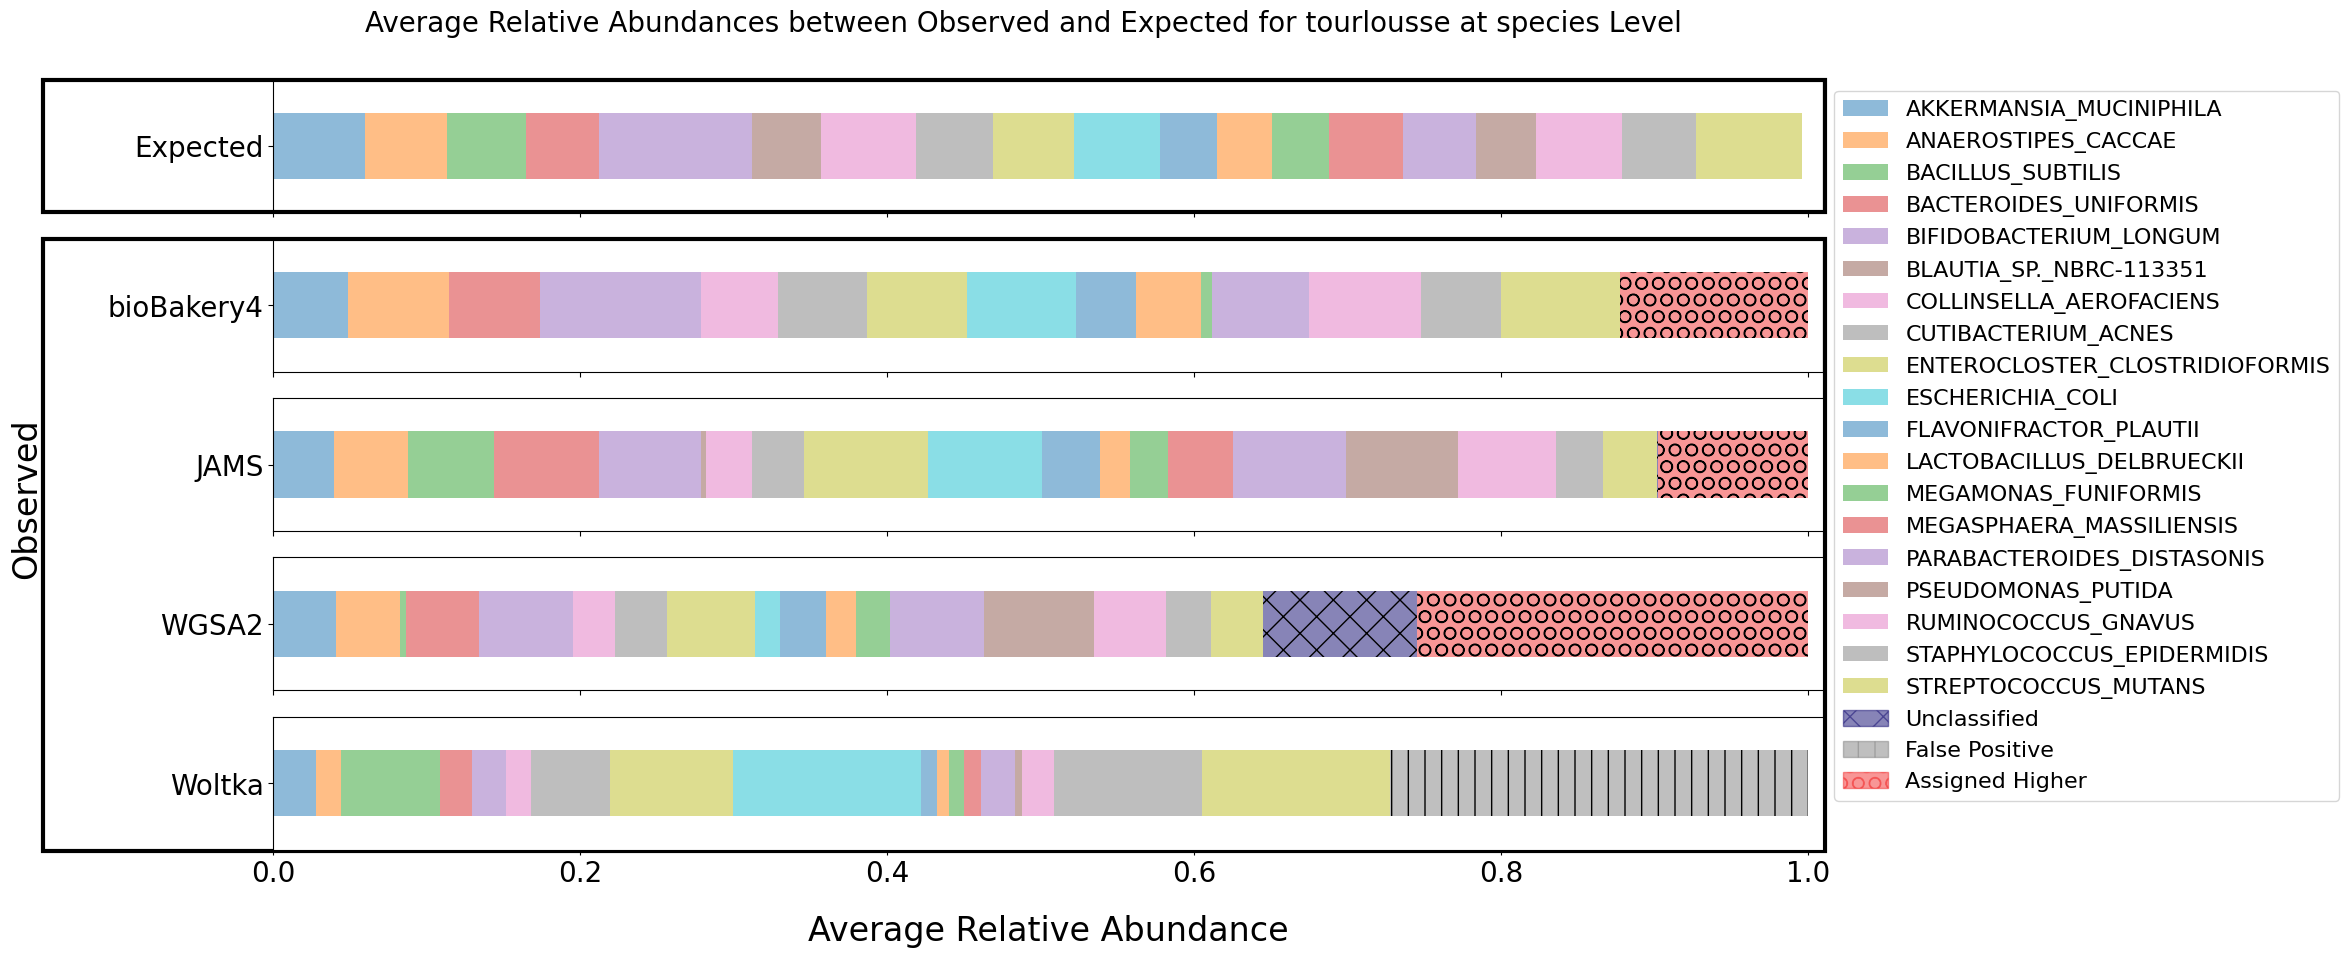

In [358]:
# Now, we want the charts to represent the left join of the expected and observed dataframes.
# This is to reduce the number of taxa.
pdf_output = PdfPages("pipeline_plotting.pdf")

def stacked_left_join(rank: str):
    expected = get_all_expected("../../pipelines/", rank=rank)
    observed = get_all_relabund_files("../../pipelines/", rank=rank)

    for src, src_df in observed.groupby("Source"):
        print(src)
        if src == "gut" or src == "tongue":
            continue

        if src == "bmock12" or src == "camisimGI" or src == "nist":
            groups = src_df.groupby("SampleID")
            for smpl, smpl_df in groups:
                print("Sample: ", smpl)
                plot_one_to_one(smpl_df, expected, src, smpl, rank)
        else:
            groups = src_df.groupby("Pipeline")

            fig, ax = plt.subplots(nrows=len(groups)+1, ncols=1, figsize=(20, 10), sharex=True)
            fig.suptitle(f"Average Relative Abundances between Observed and Expected for {src} at {rank} Level", fontsize=20, y=0.95)
            ax_c = 1

            grouped_expected = expected.loc[(expected["Source"] == src) & (expected["RA"] > 0)]
            grouped_expected = grouped_expected.copy().sort_index()
            plot_expected(ax, grouped_expected, 30)

            sorted_expected = add_row(grouped_expected, rank, "Unclassified", 0.0, UNCLASS_ID)

            for pl, pl_df in groups:
                left_joined = sorted_expected.reset_index().merge(pl_df.reset_index(), how="left", on=["TAX_ID"], suffixes=("_exp", "_obs"))

                left_joined = left_joined.loc[(left_joined["RA_exp"].notna()) | (left_joined[f"{rank}_exp"] == "Unclassified")]
                left_joined = left_joined[[f"{rank}_exp", "RA_obs", "TAX_ID"]].fillna(0)
                left_joined.rename(left_join_replace_dict, axis=1, inplace=True)
                left_joined.set_index(rank, inplace=True)

                avg_df = left_joined[['RA', 'TAX_ID']].groupby(rank).mean()

                # Get observed total.
                observed_total = avg_df["RA"].sum()

                # The difference between 1 and the observed total is assigned higher.
                assigned_higher_ra = 0
                assigned_higher_bool = False

                if pl != "woltka":
                    assigned_higher_ra = 1 - observed_total
                    assigned_higher_bool = assigned_higher_ra > 1e-6

                # Add the assigned higher to the dataframe if it is greater than 1 ppm.
                if assigned_higher_bool:
                    avg_df = add_row(avg_df, rank, "Assigned Higher", assigned_higher_ra, ASSIGNED_HIGHER_ID)

                unclassified_present = 12908 in avg_df["TAX_ID"].values

                unclassified_label = None
                if unclassified_present:
                    unclassified_label = avg_df.loc[avg_df["TAX_ID"] == 12908].index[0]
                
                # Drop the TAX_ID column.
                avg_df = avg_df.drop(columns=["TAX_ID"])

                avg_df, fp_filled = fill_df(avg_df, src, rank, "False Positive")
                # display(pl_df.head(10))
                T = avg_df[["RA"]].T

                display(T)

                T = T.reindex(sorted(T.columns), axis=1)

                reorg_list = [(unclassified_label, unclassified_present, UNCLASS), ("False Positive", fp_filled, FP), ("Assigned Higher", assigned_higher_bool, ASSIGN_HIGHER)]

                T = reorganize_columns(T, reorg_list)
                
                # Change the index to the pipeline name.
                T.index = [name_replace_dict[pl]]

                ax[ax_c].set_xlim(0, 1.01)

                T.plot.barh(alpha=0.5, legend=False, stacked=True, ax=ax[ax_c], fontsize=20)

                fix_bar_colors(ax[ax_c], reorg_list)
                                
                ax[ax_c].set_xlabel("Average Relative Abundance", fontsize=24, labelpad=20)

                ax_c += 1
            
            add_plot_decorations(ax=ax, n_rows=len(groups)+1)
            pdf_output.savefig(fig, bbox_inches="tight", dpi=300)

# stacked_left_join("genus")
stacked_left_join("species")

pdf_output.close()